In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

sys.path.append('..')
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
np.random.seed(247)
tf.set_random_seed(247)

In [2]:

rbp_names = ['Fusip', 'HuR', 'PTB', 'RBM4', 'SF2', 'SLM2', 'U1A', 'VTS1', 'YB1']

rbp_name = 'HuR'
ss_type = 'pu'
normalize_method = 'log_norm'
data_path = '../../data/RNAcompete_2009/rnacompete2009.h5'


# load rbp dataset
train, valid, test = helper.load_dataset_hdf5(data_path, dataset_name=rbp_name, ss_type=ss_type)

# process rbp dataset
train, valid, test = helper.process_data(train, valid, test, method=normalize_method)
 

/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


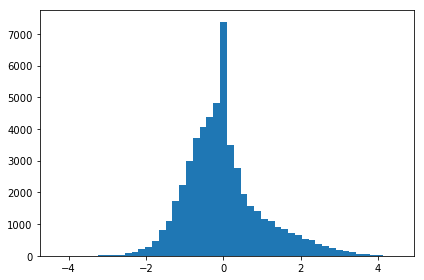

In [3]:
plt.hist(train['targets'][:,0], bins=50);

In [4]:
# set output file paths
model = 'affinity_residualbind'
genome_model = helper.import_model(model)
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape
model_layers, optimization = genome_model.model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)
nnmodel.inspect_layers()

# compile neural trainer
results_path = helper.make_directory('../../test', 'RNAcompete_2009')
save_path = helper.make_directory(results_path, normalize_method+'_'+ss_type)
file_path = os.path.join(save_path, rbp_name+'_'+model+'_'+ss_type)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 39, 1, 6)
layer2: conv1d_0
(?, 28, 1, 32)
layer3: conv1d_0_batch
(?, 28, 1, 32)
layer4: conv1d_0_active
(?, 28, 1, 32)
layer5: conv1d_0_maxpool
(?, 3, 1, 32)
layer6: conv1d_0_dropout
(?, 3, 1, 32)
layer7: conv1d_1
(?, 1, 1, 128)
layer8: conv1d_1_batch
(?, 1, 1, 128)
layer9: conv1d_1_active
(?, 1, 1, 128)
layer10: conv1d_1_dropout
(?, 1, 1, 128)
layer11: dense_0
(?, 1)
layer12: dense_0_bias
(?, 1)
layer13: output
(?, 1)
----------------------------------------------------------------------------


In [5]:
# initialize session
sess = utils.initialize_session()

In [6]:
# fit data
data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, batch_size=100, num_epochs=100, 
                      patience=20, verbose=2, shuffle=True, save_all=False)

Epoch 1 out of 100 
[==============================] 100.0% -- time=0s -- loss=0.93849 -- correlation=0.93824   
  valid loss:		0.54595
  valid Pearson's R:	0.69049+/-0.00000
  valid rsquare:	0.45961+/-0.00000
  valid slope:		1.11253+/-0.00000
  lower cross-validation found
  saving model to:  ../../test/RNAcompete_2009/log_norm_pu/HuR_affinity_conv_net_pu_best.ckpt
Epoch 2 out of 100 
[==============================] 100.0% -- time=0s -- loss=0.59264 -- correlation=0.59239   
  valid loss:		0.48422
  valid Pearson's R:	0.73527+/-0.00000
  valid rsquare:	0.51662+/-0.00000
  valid slope:		1.00760+/-0.00000
  lower cross-validation found
  saving model to:  ../../test/RNAcompete_2009/log_norm_pu/HuR_affinity_conv_net_pu_best.ckpt
Epoch 3 out of 100 
[==============================] 100.0% -- time=0s -- loss=0.53650 -- correlation=0.53625   
  valid loss:		0.44527
  valid Pearson's R:	0.75523+/-0.00000
  valid rsquare:	0.57008+/-0.00000
  valid slope:		1.18960+/-0.00000
  lower cross-vali

KeyboardInterrupt: 

In [7]:
# load best model
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, batch_size=128, name='test', verbose=1)

loading model from:  ../../test/RNAcompete_2009/log_norm_pu/HuR_affinity_conv_net_pu_best.ckpt
  test  loss:		0.34283
  test  Pearson's R:	0.81291+/-0.00000
  test  rsquare:	0.66080+/-0.00000
  test  slope:		1.07099+/-0.00000


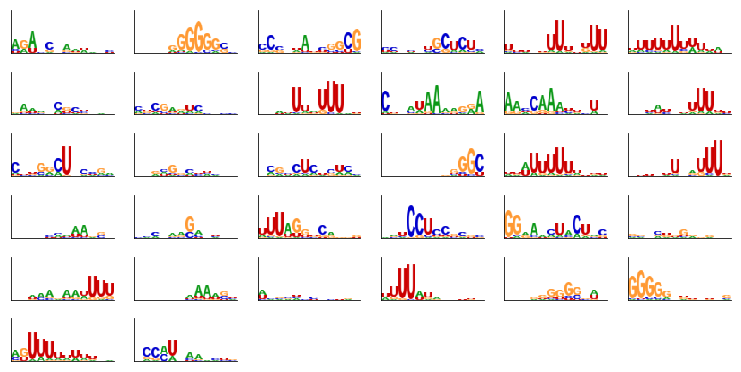

In [8]:
# plot filters
W = nnmodel.get_parameters(sess, layer='conv1d_0')[0]
fig, plt = visualize.plot_filter_logos(W[:,:,:4,:], figsize=(100,50), height=25, nt_width=10, norm=0, alphabet='rna')
#outfile = os.path.join(save_path, 'conv1_filters.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
#plt.close()

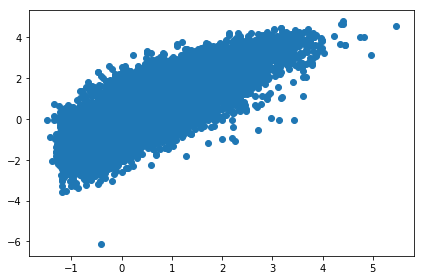

In [9]:
predictions = nntrainer.get_activations(sess, test, layer='output')
plt.scatter(predictions, test['targets'])
#outfile = os.path.join(save_path, 'test_scatter.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
#plt.close()

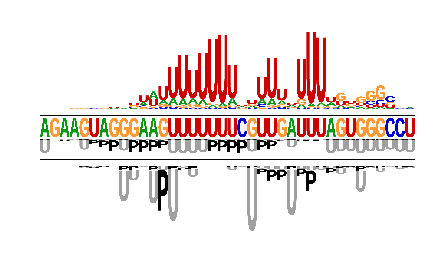

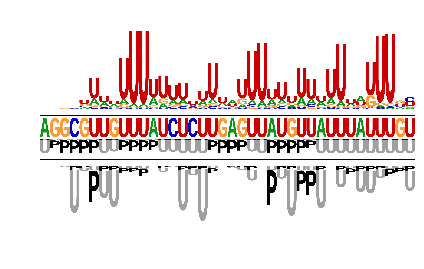

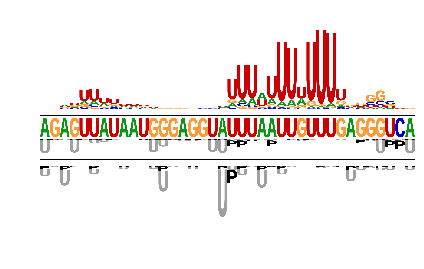

In [10]:
num_plots = 3
max_indices = np.argsort(predictions[:,0])[::-1]  
plot_range = range(0,num_plots)
plot_index = max_indices[plot_range]
X = test['inputs'][plot_index]

# parameters for saliency analysis
params = {'genome_model': genome_model.model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'model_path': file_path+'_best.ckpt',
          'optimization': optimization
         }

# guided backprop saliency
guided_saliency = saliency.guided_backprop(X, layer='output', class_index=0, params=params)
    
for i in range(num_plots):
  
    # plot saliency comparison
    fig = plt.figure()
    plt = visualize.plot_seq_struct_saliency(np.squeeze(X)[i].T, np.squeeze(guided_saliency[i]).T, nt_width=100, norm_factor=3)
    
    #output_name = '{:.2f}'.format(predictions[i,0]) + '_' + '{:.2f}'.format(data['targets'][i,0])
    #outfile = os.path.join(save_path, output_name+'.pdf')
    #fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
    #plt.close()